In [1]:
import os
import random
import functools
from time import time

import numpy as np
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import tensorflow as tf

In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tfsim-nightly
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [4]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

Physical devices cannot be modified after being initialized


In [5]:
# preprocessing function that resizes images to ensure all images are the same shape
def resize(img, label, size=300):
    with tf.device("/cpu:0"):
        img = tf.image.resize_with_pad(img, size, size)
        return img, label

In [6]:
total_num_classes = 196
training_classes = total_num_classes // 2 
examples_per_class_per_batch = 5
train_cls = random.sample(range(total_num_classes), k=training_classes)
classes_per_batch = int(80 / examples_per_class_per_batch) # max(16, training_classes)

print(f"Class IDs seen during training {train_cls}")

def img_augmentation(img_batch, y, *args, target_img_size=224):
    # random resize and crop. Increase the size before we crop.
    img_batch = tf.keras.layers.RandomCrop(target_img_size, target_img_size)(img_batch)
    # random horizontal flip
    img_batch = tf.image.random_flip_left_right(img_batch)
    return img_batch, y


# use the train split for training
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cars196",
    splits="train",
    examples_per_class_per_batch=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    preprocess_fn=functools.partial(resize, size=300),
    class_list=train_cls,
    augmenter=img_augmentation,
)  # We filter train data to only keep the train classes.

# use the test split for indexing and querying
test_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cars196",
    splits="test",
    total_examples_per_class=5,
    classes_per_batch=classes_per_batch,
    preprocess_fn=functools.partial(resize, size=300),
)

Class IDs seen during training [54, 71, 86, 188, 68, 46, 70, 99, 23, 80, 51, 91, 191, 189, 63, 144, 97, 12, 124, 93, 39, 55, 85, 1, 108, 127, 102, 16, 104, 151, 83, 25, 6, 40, 150, 15, 88, 26, 158, 96, 178, 183, 90, 182, 161, 35, 195, 72, 126, 116, 73, 159, 167, 45, 8, 38, 18, 84, 162, 9, 82, 92, 27, 113, 20, 87, 28, 42, 2, 30, 69, 47, 34, 148, 132, 21, 129, 110, 146, 13, 187, 122, 114, 41, 166, 133, 4, 61, 58, 156, 117, 22, 98, 135, 176, 109, 75, 49]


converting train:   0%|          | 0/8144 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/8144 [00:00<?, ?it/s]


The initial batch size is 80 (16 classes * 5 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/8144 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/98 [00:00<?, ?it/s]

gather examples:   0%|          | 0/4019 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/4019 [00:00<?, ?it/s]

converting test:   0%|          | 0/8041 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/8041 [00:00<?, ?it/s]


The initial batch size is 32 (16 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/8041 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/196 [00:00<?, ?it/s]

gather examples:   0%|          | 0/980 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/980 [00:00<?, ?it/s]

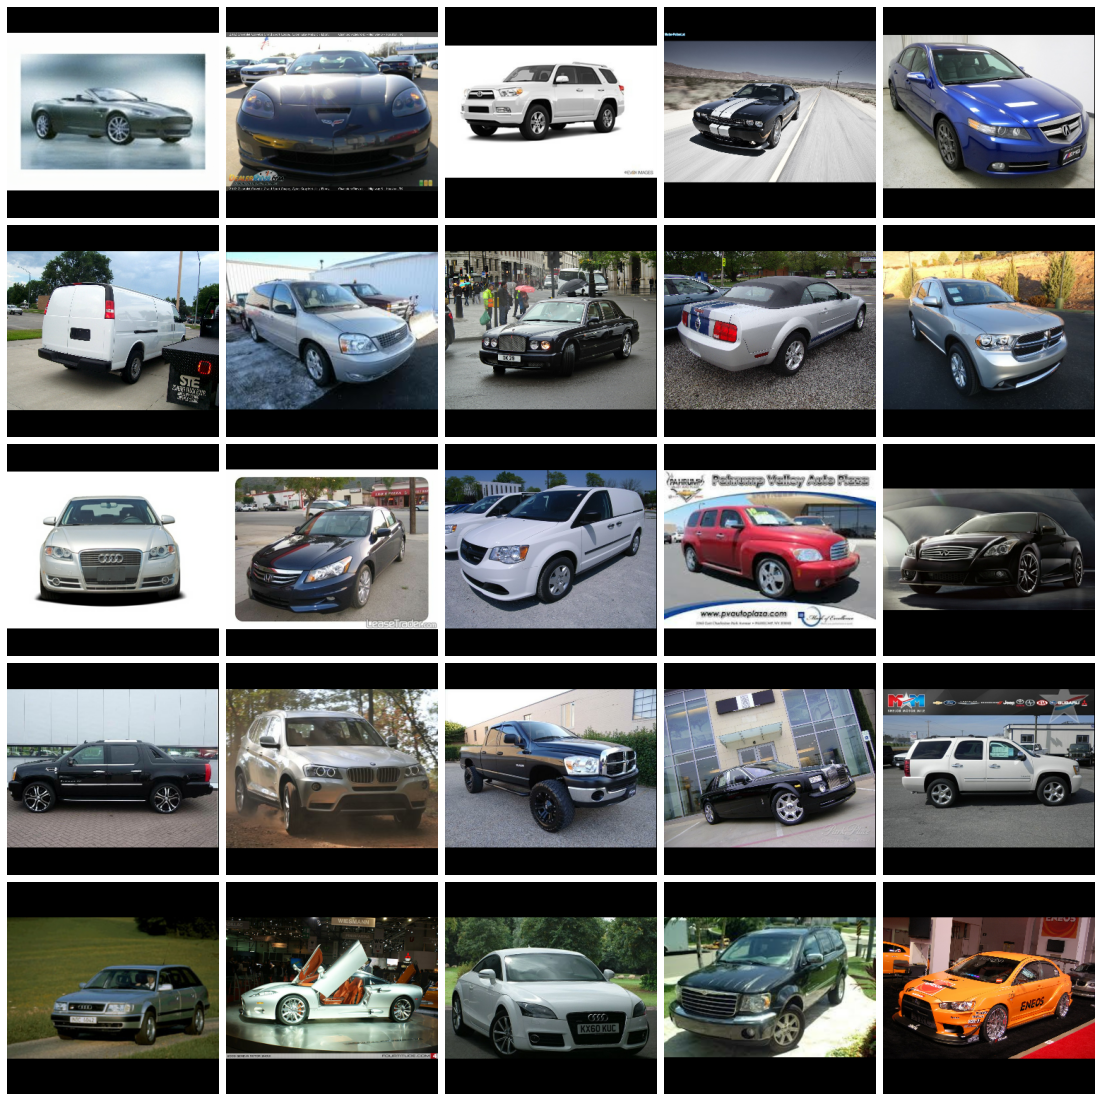

In [7]:
num_cols = num_rows = 5
# Get the first 25 examples.
x_slice, y_slice = test_ds.get_slice(begin=0, size=num_cols * num_rows)

fig = plt.figure(figsize=(20.0, 20.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

for ax, im, label in zip(grid, x_slice/255., y_slice):
    ax.imshow(im)
    ax.axis("off")

In [8]:
num_targets = 200
num_queries = 300
k = 1

# Setup EvalCallback by splitting the test data into targets and queries.
queries_x, queries_y = test_ds.get_slice(0, num_queries)
targets_x, targets_y = test_ds.get_slice(num_queries, num_targets)
# Setup SplitValidation callback.
val_loss = tfsim.callbacks.EvalCallback(
    queries_x,
    tf.cast(queries_y, dtype=tf.dtypes.int32),
    targets_x,
    tf.cast(targets_y, dtype=tf.dtypes.int32),
    metrics=["f1", "binary_accuracy"],
    known_classes=tf.constant(train_cls),
    k=k,
)

callbacks = [
    val_loss,
]

In [9]:
embedding_size = 64  # @param {type:"integer"}

# building model
model = tfsim.architectures.EfficientNetSim(
    train_ds.example_shape, 
    embedding_size,
    trainable='full',
    pooling="avg",    # Can change to use `gem` -> GeneralizedMeanPooling2D
    # gem_p=3.0,        # Increase the contrast between activations in the feature map.
)

In [ ]:
epochs = 20
LR = 0.00003
steps_per_epoch = 100
val_steps = 50


# init similarity loss
distance = "cosine"
loss = tfsim.losses.MultiSimilarityLoss(
    distance=distance,
    alpha=2.0,
    beta=40.0,
    epsilon=1e-5,
    lmda=0.5,
    center=1.0
)


# compiling and training
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=val_steps,
    callbacks=callbacks,
)

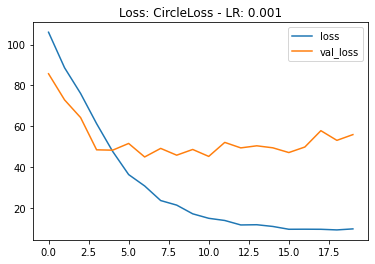

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()

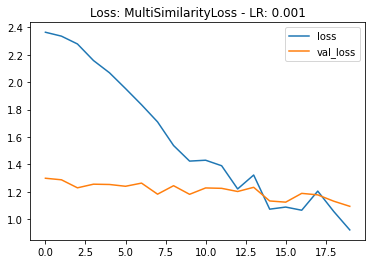

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()